In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import model_pt
from dark_emulator import model_hod
from scipy.integrate import simps
from scipy.interpolate import InterpolatedUnivariateSpline as ius
from scipy.interpolate import interp2d, interp1d
from scipy.special import jn
import numpy as np
import copy
"""
fiducial setup of matplotlib.
"""
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'serif'# 'sans-serif'
plt.rcParams['font.serif'] = "STIXGeneral"
plt.rcParams['font.size'] = 25
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['figure.figsize'] = (10,6)

plt.rc("text",usetex=True)
plt.rc("font",family="serif")
plt.rc("font",serif="STIXGeneral")

In [3]:
import logging 
mpl_logger = logging.getLogger('matplotlib') 
mpl_logger.setLevel(logging.WARNING)

In [4]:
import magnificationbias_covariance

## init & test

In [5]:
mc = magnificationbias_covariance.magnificationbias_covariance()

initialize cosmo_class
Initialize pklin emulator
set up cosmology :  [[ 0.02225  0.1198   0.6844   3.094    0.9645  -1.     ]]
set up cosmology :  [[ 0.02254  0.11417  0.721    3.094    0.97    -1.     ]]
0.020932578062250386
set up cosmology :  [[ 0.02254     0.11417     0.721       3.11493258  0.97       -1.        ]]


In [6]:
%%time
samples = ['LOWZ', 'CMASS1', 'CMASS2']
info = {}
info['zl_list'] = [0.2607,0.5106,0.6264]
info['zs'] = 1.234
info['galaxy_list'] = [1.78, 2.12, 2.28]

fsky = 0.5
Omega_s = (130.0*deg2rad(1.0)**2)
info['Omega_s'] = Omega_s
info['alpha_list'] = [2.259,3.563,3.729]
info['shape_noise'] = 0.2**2
n_s = 8.74 # arcmin^-2
info['n_s'] = n_s / deg2rad(1.0/60.0)**2

mc.prepare_dcov(info)

set up bias
{'b1': 1.78}
set up bias
{'b1': 2.12}
set up bias
{'b1': 2.28}
set up bias
{'b1': 1.78}
Got same bias parameters. Keep quantities already computed.
set up bias
{'b1': 2.12}
CPU times: user 3.71 s, sys: 12.1 ms, total: 3.72 s
Wall time: 3.72 s


In [7]:
%%time
R1 = [7.9, 8.1]
R2 = [7.9, 8.2]
mc.get_dcov(0, 0, R1, R2, show_integrand=False, dump_peak_ratio=1e2)

CPU times: user 56.1 ms, sys: 1.02 ms, total: 57.1 ms
Wall time: 56.6 ms


7.157527976695746e-05

## evaluate

In [8]:
import gglens_x_ggclustering_likelihood as utils

In [9]:
config = utils.config('config_mock_fiducial.json', load_meascorr=False)
x,y,cov = config.load_data()
n = config.probes.n_redshift['lensing']
cov_lens = cov.get_covariance('lensing')
R = x.get_radial_bin('lensing', 0)
dlogR = np.diff(np.log10(R))[0]
nr = len(R)

In [10]:
%%time
# takes ~ 3 min 
dR = np.array([10**(-dlogR/2.0),10**(dlogR/2.0)])
dcov = copy.deepcopy(cov_lens)

for i in range(n):
    for j in range(n):
        for ir in range(nr):
            for jr in range(nr):
                cov_i = nr*i + ir
                cov_j = nr*j + jr
                R1 = dR*x.get_radial_bin('lensing',i)[ir]
                R2 = dR*x.get_radial_bin('lensing',j)[jr]
                dc = mc.get_dcov(i, j, R1, R2, show_integrand=False, dump_peak_ratio=1e2)
                dcov[cov_i,cov_j] = dc

CPU times: user 2min 39s, sys: 48.2 ms, total: 2min 39s
Wall time: 2min 39s


In [14]:
# get matrix index where magnification effect covariance is larger than original cov by factor 10
index_large = np.where(abs(dcov/cov_lens) > 10)
print(len(index_large[0]))
print(index_large)

4
(array([ 8, 10, 35, 53]), array([35, 53,  8, 10]))


In [15]:
# show which element of covariance is larger than original covariance
for k in range(len(index_large[0])):
    cov_i = index_large[0][k]
    cov_j = index_large[1][k]
    i = cov_i//nr
    j = cov_j//nr
    ir = cov_i%nr
    jr = cov_j%nr
    R1 = dR*x.get_radial_bin('lensing',i)[ir]
    R2 = dR*x.get_radial_bin('lensing',j)[jr]
    #mc.get_dcov(i, j, R1, R2, show_integrand=True, dump_peak_ratio=1e2)

    c = cov_lens[cov_i][cov_j]
    dc= dcov[cov_i][cov_j]
    print('----------')
    print('R1, z1 = ',x.get_radial_bin('lensing',i)[ir], samples[i],',R1 range = ',R1)
    print('R2, z2 = ',x.get_radial_bin('lensing',j)[jr], samples[j],',R2 range = ',R2)
    print('cov      = ', c)
    print('dcov     = ', dc)
    print('dcov/cov = ', dc/c)

----------
R1, z1 =  7.7934 LOWZ ,R1 range =  [6.89167882 8.8131042 ]
R2, z2 =  71.27923 CMASS1 ,R2 range =  [63.03199627 80.60554845]
cov      =  8.87143e-07
dcov     =  5.851170216854388e-05
dcov/cov =  65.95520921491111
----------
R1, z1 =  12.74486 LOWZ ,R1 range =  [11.27023914 14.41242323]
R2, z2 =  71.27923 CMASS2 ,R2 range =  [63.03199627 80.60554845]
cov      =  -2.434568e-05
dcov     =  0.0002753476312972445
dcov/cov =  -11.309917459575765
----------
R1, z1 =  71.27923 CMASS1 ,R1 range =  [63.03199627 80.60554845]
R2, z2 =  7.7934 LOWZ ,R2 range =  [6.89167882 8.8131042 ]
cov      =  8.87143e-07
dcov     =  5.8511702168543886e-05
dcov/cov =  65.95520921491111
----------
R1, z1 =  71.27923 CMASS2 ,R1 range =  [63.03199627 80.60554845]
R2, z2 =  12.74486 LOWZ ,R2 range =  [11.27023914 14.41242323]
cov      =  -2.434568e-05
dcov     =  0.0002753476312972445
dcov/cov =  -11.309917459575765


In [16]:
# useful 
def investigate(k, show_integrand=True, show_order=True, print_info=True, show_summand_order=True):
    cov_i = index_large[0][k]
    cov_j = index_large[1][k]
    i = cov_i//nr
    j = cov_j//nr
    ir = cov_i%nr
    jr = cov_j%nr
    R1 = dR*x.get_radial_bin('lensing',i)[ir]
    R2 = dR*x.get_radial_bin('lensing',j)[jr]
    mc.get_dcov(i, j, R1, R2, show_integrand=show_integrand, dump_peak_ratio=1e2, 
                show_order=show_order, show_summand_order=show_summand_order)

    c = cov_lens[cov_i][cov_j]
    dc= dcov[cov_i][cov_j]
    if print_info:
        print('R1, z1 = ',x.get_radial_bin('lensing',i)[ir], samples[i],',R1 range = ',R1)
        print('R2, z2 = ',x.get_radial_bin('lensing',j)[jr], samples[j],',R2 range = ',R2)
        print('cov      = ', c)
        print('dcov     = ', dc)
        print('dcov/cov = ', dc/c)

In [17]:
# show which C(l) is largest in computation of the large covariance element.
for k in range(len(index_large[0])):
    investigate(k, show_integrand=False, show_order=True, print_info=False, show_summand_order=False)

max = C_gl = 4.110135e-06 = O(10^{-5})
max = C_gl = 5.210846e-06 = O(10^{-5})
max = C_gl = 4.110135e-06 = O(10^{-5})
max = C_gl = 5.210846e-06 = O(10^{-5})


In [18]:
# show which C(l)*C(l) is largest in computation of the large covariance element.
for k in range(len(index_large[0])):
    investigate(k, show_integrand=False, show_order=False, print_info=False, show_summand_order=True)

max summand = C_gs[1] * C_ls[2] = 2.378198e-13
max summand = C_gs[1] * C_ls[2] = 2.879078e-13
max summand = C_gs[2] * C_ls[1] = 2.378198e-13
max summand = C_gs[2] * C_ls[1] = 2.879078e-13


/work/sunao.sugiyama/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: AutoMinorLocator does not work with logarithmic scale
  fig.canvas.print_figure(bytes_io, **kw)
/work/sunao.sugiyama/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: AutoMinorLocator does not work with logarithmic scale
  fig.canvas.print_figure(bytes_io, **kw)
/work/sunao.sugiyama/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: AutoMinorLocator does not work with logarithmic scale
  fig.canvas.print_figure(bytes_io, **kw)


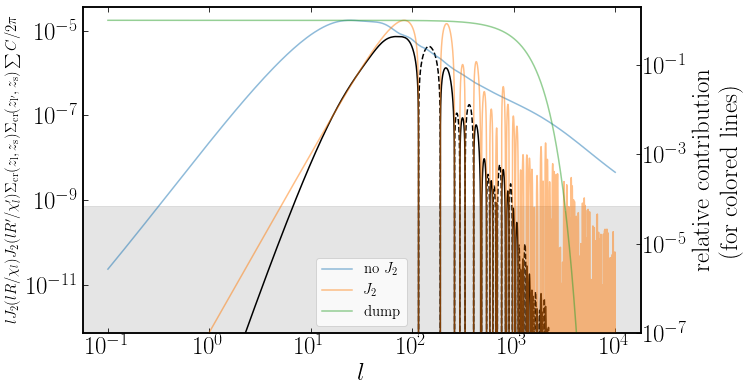

max = C_gl = 5.210846e-06 = O(10^{-5})
max summand = C_gs[1] * C_ls[2] = 2.879078e-13
R1, z1 =  12.74486 LOWZ ,R1 range =  [11.27023914 14.41242323]
R2, z2 =  71.27923 CMASS2 ,R2 range =  [63.03199627 80.60554845]
cov      =  -2.434568e-05
dcov     =  0.0002753476312972445
dcov/cov =  -11.309917459575765


In [19]:
# show various infomation for the large covariance matrix
# I can see which l has large contribution
# - black: integrand. integration of black line gives covariance element
# - blue : sum of C(l)*C(l)
# - orange : J_2(lR/x) * J2(lR/x')
# - green : artificial dumping function to supress highly oscilating C(l) at l> l_dump = (factor)*R/x
#           The factor in l_dump is 100 by default, meaning dumping scale is larger than peak position by factor 100
#           The factor in l_dump can be changed with optional argument `dump_peak_ratio` in `get_cov` method
investigate(1)

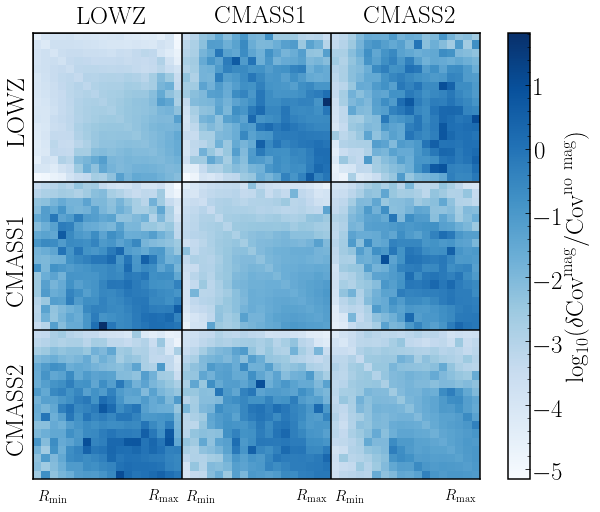

In [20]:
fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(np.log10(abs(dcov/cov_lens)), cmap='Blues')
cbar = fig.colorbar(im)
cbar.ax.set_ylabel(r'$\log_{10}(\delta{\rm Cov}^{\rm mag}/{\rm Cov}^{\rm no~mag})$')
ax_pos = ax.get_position()
cbar_pos0 = cbar.ax.get_position()
cbar_pos1 = [cbar_pos0.x0, ax_pos.y0, cbar_pos0.x1 - cbar_pos0.x0, ax_pos.y1 - ax_pos.y0]
cbar.ax.set_position(cbar_pos1)
for i in range(n):
    ax.axhline(i*nr-0.5, color='k')
    ax.axvline(i*nr-0.5, color='k')
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.tick_params(axis='both', which='minor', length=0)
ax.tick_params(axis='both', which='major', length=0)
for i in range(n):
    ax.text((i+0.5)*nr, -1, samples[i], ha="center", va="bottom")
    ax.text(-1, (i+0.5)*nr, samples[i], ha="right", va="center", rotation=90)
for i in range(n):
    ax.text(0 +i*nr    , nr*n+1, r'$R_{\rm min}$', ha='left' , va='top',fontsize=15)
    ax.text(nr+i*nr-1.0, nr*n+1, r'$R_{\rm max}$', ha='right', va='top',fontsize=15)

In [21]:
sel = abs(dcov/cov_lens) > 1
high = np.zeros(dcov.shape)
high[sel] = 1.0

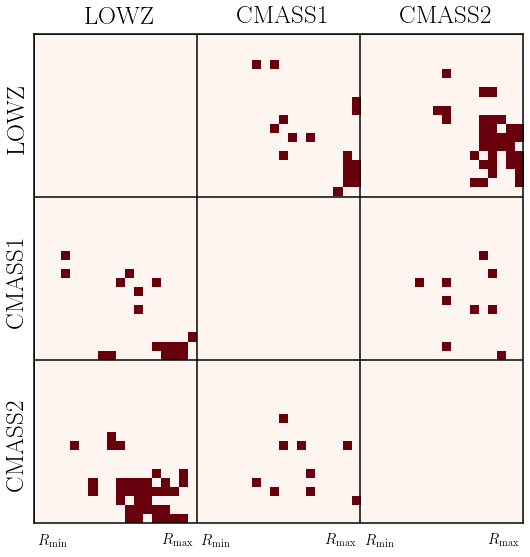

In [22]:
fig, ax = plt.subplots(figsize=(9,9))
im = ax.imshow(high, cmap='Reds')
#cbar = fig.colorbar(im)
#cbar.ax.set_ylabel(r'$log_{10}(\delta{\rm Cov}^{\rm mag}/{\rm Cov}^{\rm no~mag})$')
#ax_pos = ax.get_position()
#cbar_pos0 = cbar.ax.get_position()
#cbar_pos1 = [cbar_pos0.x0, ax_pos.y0, cbar_pos0.x1 - cbar_pos0.x0, ax_pos.y1 - ax_pos.y0]
#cbar.ax.set_position(cbar_pos1)
for i in range(n):
    ax.axhline(i*nr-0.5, color='k')
    ax.axvline(i*nr-0.5, color='k')
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.tick_params(axis='both', which='minor', length=0)
ax.tick_params(axis='both', which='major', length=0)
for i in range(n):
    ax.text((i+0.5)*nr, -1, samples[i], ha="center", va="bottom")
    ax.text(-1, (i+0.5)*nr, samples[i], ha="right", va="center", rotation=90)
for i in range(n):
    ax.text(0 +i*nr    , nr*n+1, r'$R_{\rm min}$', ha='left' , va='top',fontsize=15)
    ax.text(nr+i*nr-1.0, nr*n+1, r'$R_{\rm max}$', ha='right', va='top',fontsize=15)

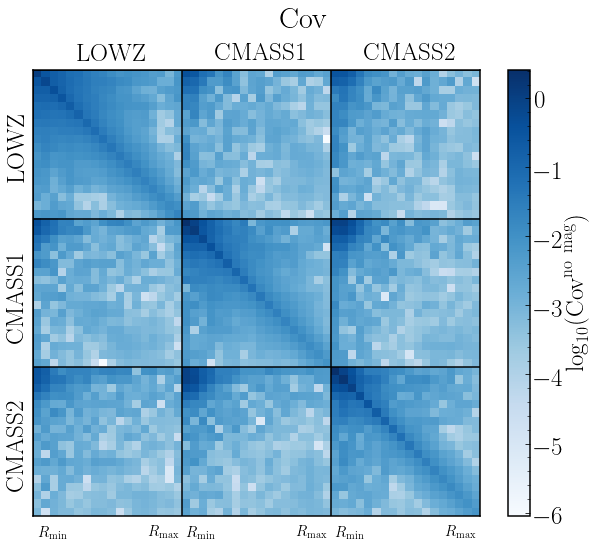

In [23]:
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle(r'${\rm Cov}$', y=0.9)
im = ax.imshow(np.log10(abs(cov_lens)), cmap='Blues')
cbar = fig.colorbar(im)
cbar.ax.set_ylabel(r'$\log_{10}({\rm Cov}^{\rm no~mag})$')
ax_pos = ax.get_position()
cbar_pos0 = cbar.ax.get_position()
cbar_pos1 = [cbar_pos0.x0, ax_pos.y0, cbar_pos0.x1 - cbar_pos0.x0, ax_pos.y1 - ax_pos.y0]
cbar.ax.set_position(cbar_pos1)
for i in range(n):
    ax.axhline(i*nr-0.5, color='k')
    ax.axvline(i*nr-0.5, color='k')
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.tick_params(axis='both', which='minor', length=0)
ax.tick_params(axis='both', which='major', length=0)
for i in range(n):
    ax.text((i+0.5)*nr, -1, samples[i], ha="center", va="bottom")
    ax.text(-1, (i+0.5)*nr, samples[i], ha="right", va="center", rotation=90)
for i in range(n):
    ax.text(0 +i*nr    , nr*n+1, r'$R_{\rm min}$', ha='left' , va='top',fontsize=15)
    ax.text(nr+i*nr-1.0, nr*n+1, r'$R_{\rm max}$', ha='right', va='top',fontsize=15)

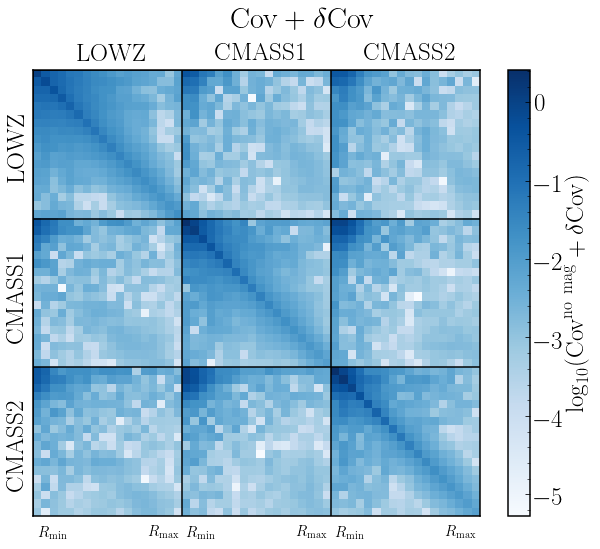

In [24]:
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle(r'${\rm Cov}+\delta{\rm Cov}$', y=0.9)
im = ax.imshow(np.log10(abs(cov_lens+dcov)), cmap='Blues')
cbar = fig.colorbar(im)
cbar.ax.set_ylabel(r'$\log_{10}({\rm Cov}^{\rm no~mag}+\delta{\rm Cov})$')
ax_pos = ax.get_position()
cbar_pos0 = cbar.ax.get_position()
cbar_pos1 = [cbar_pos0.x0, ax_pos.y0, cbar_pos0.x1 - cbar_pos0.x0, ax_pos.y1 - ax_pos.y0]
cbar.ax.set_position(cbar_pos1)
for i in range(n):
    ax.axhline(i*nr-0.5, color='k')
    ax.axvline(i*nr-0.5, color='k')
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.tick_params(axis='both', which='minor', length=0)
ax.tick_params(axis='both', which='major', length=0)
for i in range(n):
    ax.text((i+0.5)*nr, -1, samples[i], ha="center", va="bottom")
    ax.text(-1, (i+0.5)*nr, samples[i], ha="right", va="center", rotation=90)
for i in range(n):
    ax.text(0 +i*nr    , nr*n+1, r'$R_{\rm min}$', ha='left' , va='top',fontsize=15)
    ax.text(nr+i*nr-1.0, nr*n+1, r'$R_{\rm max}$', ha='right', va='top',fontsize=15)

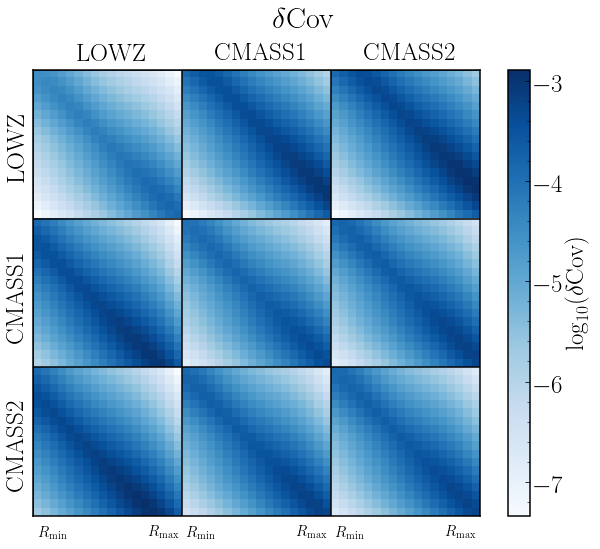

In [25]:
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle(r'$\delta{\rm Cov}$', y=0.9)
im = ax.imshow(np.log10(abs(dcov)), cmap='Blues')
cbar = fig.colorbar(im)
cbar.ax.set_ylabel(r'$\log_{10}(\delta{\rm Cov})$')
ax_pos = ax.get_position()
cbar_pos0 = cbar.ax.get_position()
cbar_pos1 = [cbar_pos0.x0, ax_pos.y0, cbar_pos0.x1 - cbar_pos0.x0, ax_pos.y1 - ax_pos.y0]
cbar.ax.set_position(cbar_pos1)
for i in range(n):
    ax.axhline(i*nr-0.5, color='k')
    ax.axvline(i*nr-0.5, color='k')
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.tick_params(axis='both', which='minor', length=0)
ax.tick_params(axis='both', which='major', length=0)
for i in range(n):
    ax.text((i+0.5)*nr, -1, samples[i], ha="center", va="bottom")
    ax.text(-1, (i+0.5)*nr, samples[i], ha="right", va="center", rotation=90)
for i in range(n):
    ax.text(0 +i*nr    , nr*n+1, r'$R_{\rm min}$', ha='left' , va='top',fontsize=15)
    ax.text(nr+i*nr-1.0, nr*n+1, r'$R_{\rm max}$', ha='right', va='top',fontsize=15)

In [26]:
dr = copy.deepcopy(dcov)
for i in range(dr.shape[0]):
    for j in range(dr.shape[0]):
        dr[i][j] /= (cov_lens[i,i]*cov_lens[j,j])**0.5

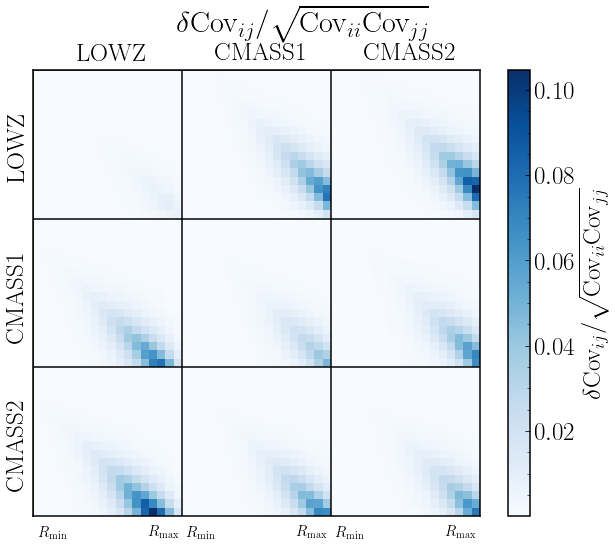

In [49]:
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle(r'$\delta{\rm Cov}_{ij}/\sqrt{{\rm Cov}_{ii}{\rm Cov}_{jj}}$', y=0.9)
im = ax.imshow((abs(dr)), cmap='Blues')
cbar = fig.colorbar(im)
cbar.ax.set_ylabel(r'$\delta{\rm Cov}_{ij}/\sqrt{{\rm Cov}_{ii}{\rm Cov}_{jj}}$')
ax_pos = ax.get_position()
cbar_pos0 = cbar.ax.get_position()
cbar_pos1 = [cbar_pos0.x0, ax_pos.y0, cbar_pos0.x1 - cbar_pos0.x0, ax_pos.y1 - ax_pos.y0]
cbar.ax.set_position(cbar_pos1)
for i in range(n):
    ax.axhline(i*nr-0.5, color='k')
    ax.axvline(i*nr-0.5, color='k')
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.tick_params(axis='both', which='minor', length=0)
ax.tick_params(axis='both', which='major', length=0)
for i in range(n):
    ax.text((i+0.5)*nr, -1, samples[i], ha="center", va="bottom")
    ax.text(-1, (i+0.5)*nr, samples[i], ha="right", va="center", rotation=90)
for i in range(n):
    ax.text(0 +i*nr    , nr*n+1, r'$R_{\rm min}$', ha='left' , va='top',fontsize=15)
    ax.text(nr+i*nr-1.0, nr*n+1, r'$R_{\rm max}$', ha='right', va='top',fontsize=15)

In [28]:
np.max(dr)

covariance(0.10475327)

In [47]:
compara = np.zeros(dr.shape)
sel = dr > 0.05
compara[sel] = 1

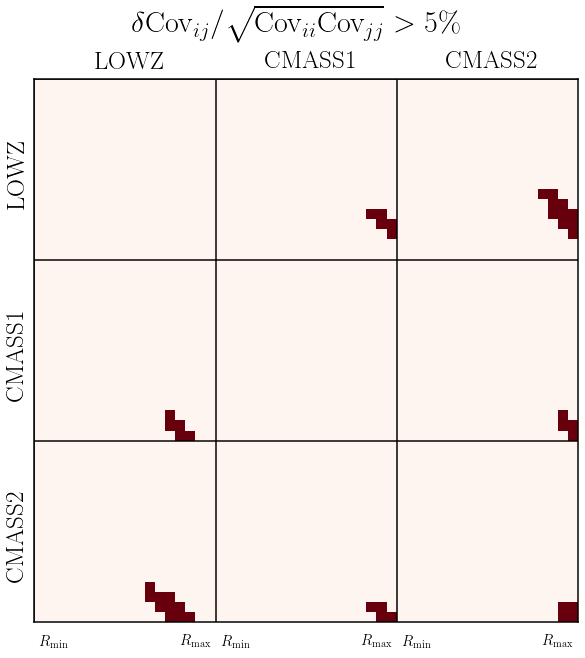

In [48]:
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle(r'$\delta{\rm Cov}_{ij}/\sqrt{{\rm Cov}_{ii}{\rm Cov}_{jj}} > 5\%$', y=0.98)
im = ax.imshow(compara, cmap='Reds')
for i in range(n):
    ax.axhline(i*nr-0.5, color='k')
    ax.axvline(i*nr-0.5, color='k')
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.tick_params(axis='both', which='minor', length=0)
ax.tick_params(axis='both', which='major', length=0)
for i in range(n):
    ax.text((i+0.5)*nr, -1, samples[i], ha="center", va="bottom")
    ax.text(-1, (i+0.5)*nr, samples[i], ha="right", va="center", rotation=90)
for i in range(n):
    ax.text(0 +i*nr    , nr*n+1, r'$R_{\rm min}$', ha='left' , va='top',fontsize=15)
    ax.text(nr+i*nr-1.0, nr*n+1, r'$R_{\rm max}$', ha='right', va='top',fontsize=15)

### C(l) exmaple

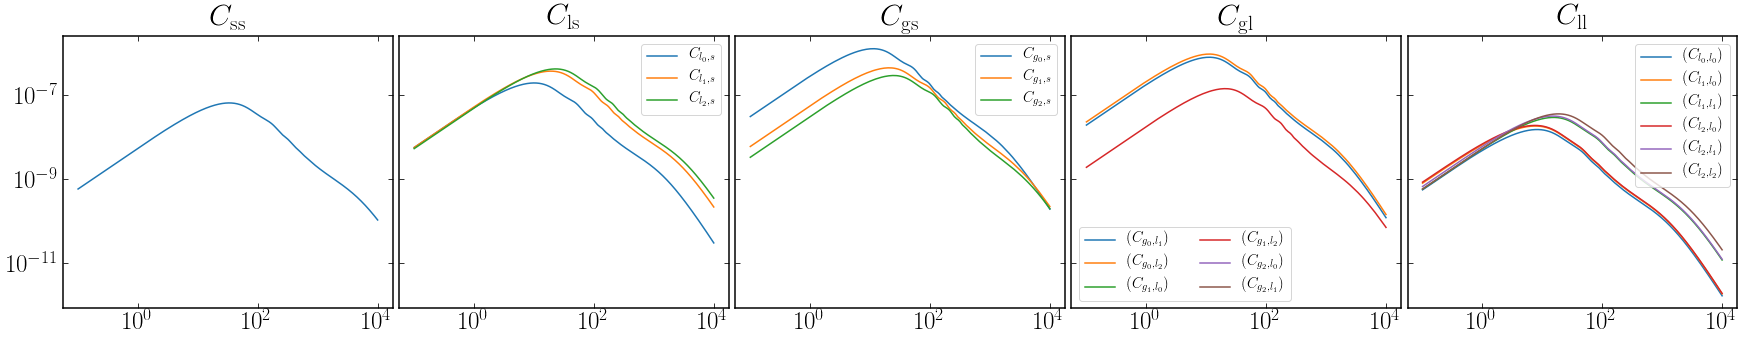

In [31]:
fig, axes = plt.subplots(1,5, figsize=(30, 5), sharey=True)
plt.subplots_adjust(wspace=0.02)
n = len(mc.C_ls)
fs = 15

ax = axes[0]
ax.set_title(r'$C_{\rm ss}$')
ax.loglog(mc.l, mc.C_ss)

ax = axes[1]
ax.set_title(r'$C_{\rm ls}$')
for i in range(n):
    ax.loglog(mc.l, mc.C_ls[i], label=r'$C_{l_%s, s}$'%i)
ax.legend(fontsize=fs)
    
ax = axes[2]
ax.set_title(r'$C_{\rm gs}$')
for i in range(n):
    ax.loglog(mc.l, mc.C_gs[i], label=r'$C_{g_%s, s}$'%i)
ax.legend(fontsize=fs)
    
ax = axes[3]
ax.set_title(r'$C_{\rm gl}$')
for i in range(n):
    for j in range(n):
        ax.loglog(mc.l, mc.C_gl[i][j], label=r'$(C_{g_%d,l_%d})$'%(i,j)) if i!=j else None
ax.legend(fontsize=fs, ncol=2)
        
ax = axes[4]
ax.set_title(r'$C_{\rm ll}$')
for i in range(n):
    for j in range(i+1):
        ax.loglog(mc.l, mc.C_ll[i][j], label=r'$(C_{l_%d,l_%d})$'%(i,j))
ax.legend(fontsize=fs)

plt.show()
